In [1]:

%reload_ext autoreload
%autoreload 2

from func import *
import pandas as pd
import pickle
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler



In [2]:
filename = 'all_data_anonymized.csv'
date_col = 'todate'
start_date = '1980-01-01'
seperator = ';'
fill = 0
lim = 5
df_read = load_and_preprocess_data(filename, date_col, start_date, seperator, fill, lim)


c:\Users\osaz001\Master-thesis\Files\func.py:26: DtypeWarning: Columns (15,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_read = pd.read_csv(filename, sep=seperator)


In [3]:
#windows_d = [5, 10, 20, 40, 60, 100, 180, 240, 360, 480]
window_m = [10, 30, 60, 100, 180]
assets = df_read.columns
df_feat = add_features(df_read, window_m)

In [4]:
target_days = 5
holding_period = 3
cross = True
return_column_shift = 'avgreturn'
volatility_column_shift = 'volatility'
df = add_y_col(df_feat, df_read, date_col, target_days, return_column_shift, volatility_column_shift, cross)

In [75]:
X_train, X_eval, X_test_full, y_train, y_eval, y_test_full, X_train_eval, y_train_eval = prepare_training_dataset(df, date_col, shuffle=False, train_split=0.25, eval_split=0.25)

In [76]:
import pandas as pd

all_portfolios = {
    'lgb': pd.DataFrame(),
    'ridge': pd.DataFrame(),
    'NN': pd.DataFrame(),
    'benchmark': pd.DataFrame(),
}
# Initial training and testing periods
end_test_date = df.loc[X_eval.index.max(), 'todate'] +  pd.DateOffset(years=holding_period)  # 3 years test period
start_train_idx = df.index.min()
end_train_idx = X_eval.index.max()

if end_test_date not in df[date_col]:
    end_test_idx = df.index[df[date_col] <= end_test_date].max()

else:
    closest_date = end_test_date
    end_test_idx = df.index.get_loc(closest_date)
end_test_date_set_to_max = False


# Defining your model parameters and training functions here, assuming they are already defined as in your code.



while pd.to_datetime(end_test_date) <= df['todate'].max():
    # Slice the training and test datasets based on the dates
    
    X_test = X_test_full.loc[end_train_idx+1:end_test_idx]
    y_test = y_test_full.loc[end_train_idx+1:end_test_idx]

    # Check if X_test and y_test are not empty
    if X_test.empty or y_test.empty:
        print(end_train_idx, end_test_idx, "Empty test dataset.")
        print(closest_date, end_test_idx)
        break
    param_grid_NN = {
        'optimizer': ['adam', 'rmsprop'],
        'epochs': [50],  
        'batch_size': [32, 64]
    }

    NN_model, best_params, X_test_scaled = optimize_and_train_NN(X_train, y_train, X_eval, y_eval, X_test, param_grid_NN, cross)

    param_grid_alpha = {'alpha': [0.1, 1.0, 10.0]}
    ridge_best, grid_search = optimize_and_train_ridge(X_train, y_train, X_eval, y_eval, param_grid_alpha, cross)


    param_grid_lgb = {
        'max_depth': [3, 6, 10],
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 63, 127, 255]
    }


    lgb_best, best_params = optimize_and_train_lgb(X_train, y_train, X_eval, y_eval, param_grid_lgb, cross)
    
    ## 
    df_2 = df.loc[X_test.index]
    # Use the dates in df_2 to filter rows in df_read
    df_2_read = df_read.loc[df_2[date_col].unique()]

    # fill missing values with 0
    df_2_read.fillna(0, inplace=True)


    ##
    models = {
        'lgb': lgb_best,
        'ridge': ridge_best,
        'NN': NN_model,
        'benchmark': None
    }


    df_2_neutral = df_2_read.copy()

    for col in df_2_neutral.columns:
        df_2_neutral[col] = 0  


    model_dfs = {
        'lgb': df_2_neutral.copy(),
        'ridge': df_2_neutral.copy(),
        'NN': df_2_neutral.copy(),
        'benchmark': df_2_neutral.copy()
    }

    ##
        
    signals_dfs = {
        'lgb': df_2_neutral.copy(),
        'ridge': df_2_neutral.copy(),
        'NN': df_2_neutral.copy(),
        'benchmark': df_2_neutral.copy()
    }

    portfolio_dfs = {
        'lgb': df_2_neutral.copy(),
        'ridge': df_2_neutral.copy(),
        'NN': df_2_neutral.copy(),
        'benchmark': df_2_neutral.copy()
    }

    for name, model in models.items():
        best_assets, worst_assets = predict_and_analyze_ext(model, X_test, df, name, df_read, date_col, cross, top_percentile=70, bottom_percentile=30) 
        assets_df = pd.concat([best_assets, worst_assets])
        assets_df['update_value'] = 0
        assets_df.loc[assets_df[name] > assets_df['top_threshold'], 'update_value'] = 1
        assets_df.loc[assets_df[name] < assets_df['bottom_threshold'], 'update_value'] = -1

        pivot_df = assets_df.pivot_table(index='todate', columns='asset', values='update_value', fill_value=0)
        signals_dfs[name].update(pivot_df)

        portfolio_dfs[name] = update_df_with_asset_performance(signals_dfs[name], portfolio_dfs[name], target_days, df_read)
        all_portfolios[name] = pd.concat([all_portfolios[name], portfolio_dfs[name]])

    
    # Update the training dataset to include the current test dataset for the next cycle
    end_train_date = end_test_date
    end_test_date = pd.to_datetime(end_test_date) + pd.DateOffset(years=3)  # Shift test period by 3 years
    # Check to ensure we do not exceed the data boundary
    """if pd.to_datetime(end_test_date) > df['todate'].max():
        print("Reached the end of available data.")
        print(df.index.get_loc(end_test_date))
        break"""

    if pd.to_datetime(end_test_date) > df['todate'].max():
        if not end_test_date_set_to_max:
            print("Reached the end of available data in first iteration.")
            end_test_date = df['todate'].max()
            end_test_date_set_to_max = True
            if end_test_date not in df[date_col]:
                end_test_idx = df.index[df[date_col] <= end_test_date].max()
            else:
                closest_date = end_test_date
                end_test_idx = df.index.get_loc(closest_date)
            print(f"Updated end_test_idx to last date: {end_test_idx}")  # Debugging print
        else:
            print("Reached the end of available data.")
            break
    # add X_test to X_eval
    X_eval = pd.concat([X_eval, X_test])
    y_eval = pd.concat([y_eval, y_test])

    # Update the indices for the next cycle
    start_train_idx = end_train_idx + 1
    end_train_idx = X_eval.index.max()
    if end_test_date not in df[date_col]:
        end_test_idx = df.index[df[date_col] <= end_test_date].max()

    else:
        closest_date = end_test_date
        end_test_idx = df.index.get_loc(closest_date)







c:\appl\Anaconda3\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\appl\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best hyperparameters: {'batch_size': 64, 'epochs': 50, 'optimizer': 'rmsprop'}
Epoch 1/50


c:\appl\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1521/1521 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5324 - loss: 0.2488 - val_accuracy: 0.5414 - val_loss: 0.2473
Epoch 2/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5521 - loss: 0.2458 - val_accuracy: 0.5452 - val_loss: 0.2472
Epoch 3/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5550 - loss: 0.2451 - val_accuracy: 0.5458 - val_loss: 0.2473
Epoch 4/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5589 - loss: 0.2445 - val_accuracy: 0.5421 - val_loss: 0.2485
Epoch 5/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5674 - loss: 0.2428 - val_accuracy: 0.5366 - val_loss: 0.2492
Epoch 6/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5678 - loss: 0.2427 - val_accuracy: 0.5388 - val_loss: 0.2493
Epoch 7/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5725 - loss: 0.2418 - val_accuracy: 0.5325 - val_loss: 0.2497
Epoch 8/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5772 - loss: 0.2409 - val_accurac

c:\Users\osaz001\Master-thesis\Files\func.py:567: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))


1398/1398 ━━━━━━━━━━━━━━━━━━━━ 1s 963us/step


c:\Users\osaz001\Master-thesis\Files\func.py:567: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
c:\Users\osaz001\Master-thesis\Files\func.py:567: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
c:\appl\Anaconda3\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\appl\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best hyperparameters: {'batch_size': 64, 'epochs': 50, 'optimizer': 'adam'}
Epoch 1/50


c:\appl\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1521/1521 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5364 - loss: 0.2486 - val_accuracy: 0.5467 - val_loss: 0.2468
Epoch 2/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5514 - loss: 0.2464 - val_accuracy: 0.5472 - val_loss: 0.2471
Epoch 3/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5541 - loss: 0.2457 - val_accuracy: 0.5462 - val_loss: 0.2468
Epoch 4/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5575 - loss: 0.2451 - val_accuracy: 0.5388 - val_loss: 0.2478
Epoch 5/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5612 - loss: 0.2442 - val_accuracy: 0.5453 - val_loss: 0.2485
Epoch 6/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5634 - loss: 0.2437 - val_accuracy: 0.5446 - val_loss: 0.2479
Epoch 7/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5666 - loss: 0.2430 - val_accuracy: 0.5361 - val_loss: 0.2490
Epoch 8/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5735 - loss: 0.2415 - val_accurac

c:\Users\osaz001\Master-thesis\Files\func.py:567: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
c:\Users\osaz001\Master-thesis\Files\func.py:567: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
c:\Users\osaz001\Master-thesis\Files\func.py:567: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
c:\appl\Anaconda3\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\appl\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init

Best hyperparameters: {'batch_size': 32, 'epochs': 50, 'optimizer': 'adam'}
Epoch 1/50


c:\appl\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3041/3041 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5296 - loss: 0.2491 - val_accuracy: 0.5474 - val_loss: 0.2469
Epoch 2/50
3041/3041 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5502 - loss: 0.2463 - val_accuracy: 0.5473 - val_loss: 0.2480
Epoch 3/50
3041/3041 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5538 - loss: 0.2457 - val_accuracy: 0.5463 - val_loss: 0.2477
Epoch 4/50
3041/3041 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5558 - loss: 0.2451 - val_accuracy: 0.5469 - val_loss: 0.2481
Epoch 5/50
3041/3041 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5571 - loss: 0.2444 - val_accuracy: 0.5435 - val_loss: 0.2473
Epoch 6/50
3041/3041 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5606 - loss: 0.2438 - val_accuracy: 0.5401 - val_loss: 0.2490
Epoch 7/50
3041/3041 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5654 - loss: 0.2431 - val_accuracy: 0.5396 - val_loss: 0.2486
Epoch 8/50
3041/3041 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5670 - loss: 0.2422 - val_accura

c:\Users\osaz001\Master-thesis\Files\func.py:567: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
c:\appl\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\appl\Anaconda3\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\appl\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best hyperparameters: {'batch_size': 64, 'epochs': 50, 'optimizer': 'rmsprop'}
Epoch 1/50


c:\appl\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1521/1521 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5330 - loss: 0.2488 - val_accuracy: 0.5394 - val_loss: 0.2477
Epoch 2/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5513 - loss: 0.2461 - val_accuracy: 0.5330 - val_loss: 0.2486
Epoch 3/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5559 - loss: 0.2449 - val_accuracy: 0.5385 - val_loss: 0.2488
Epoch 4/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5594 - loss: 0.2444 - val_accuracy: 0.5345 - val_loss: 0.2494
Epoch 5/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5631 - loss: 0.2433 - val_accuracy: 0.5346 - val_loss: 0.2494
Epoch 6/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5683 - loss: 0.2426 - val_accuracy: 0.5314 - val_loss: 0.2496
Epoch 7/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5726 - loss: 0.2422 - val_accuracy: 0.5363 - val_loss: 0.2507
Epoch 8/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5751 - loss: 0.2414 - val_accurac

c:\Users\osaz001\Master-thesis\Files\func.py:567: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))


1405/1405 ━━━━━━━━━━━━━━━━━━━━ 1s 930us/step


c:\Users\osaz001\Master-thesis\Files\func.py:567: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
c:\Users\osaz001\Master-thesis\Files\func.py:567: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
c:\Users\osaz001\Master-thesis\Files\func.py:567: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))


Reached the end of available data in first iteration.
Updated end_test_idx to last date: 516554


c:\appl\Anaconda3\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\appl\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best hyperparameters: {'batch_size': 32, 'epochs': 50, 'optimizer': 'rmsprop'}
Epoch 1/50


c:\appl\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3041/3041 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5301 - loss: 0.2490 - val_accuracy: 0.5430 - val_loss: 0.2473
Epoch 2/50
3041/3041 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5491 - loss: 0.2467 - val_accuracy: 0.5400 - val_loss: 0.2493
Epoch 3/50
3041/3041 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.5505 - loss: 0.2461 - val_accuracy: 0.5439 - val_loss: 0.2482
Epoch 4/50
3041/3041 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5580 - loss: 0.2449 - val_accuracy: 0.5340 - val_loss: 0.2493
Epoch 5/50
3041/3041 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5596 - loss: 0.2442 - val_accuracy: 0.5309 - val_loss: 0.2505
Epoch 6/50
3041/3041 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5608 - loss: 0.2442 - val_accuracy: 0.5326 - val_loss: 0.2500
Epoch 7/50
3041/3041 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5691 - loss: 0.2428 - val_accuracy: 0.5350 - val_loss: 0.2499
Epoch 8/50
3041/3041 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.5664 - loss: 0.2427 - val

In [105]:
# Store predictions in a dictionary
predictions = {
    "Ridge Classifier": ridge_best.predict(X_test),
    "LightGBM Classifier": lgb_best.predict(X_test),
    "Neural Network": NN_model.predict(X_test_scaled)
}   

# Iterate through the dictionary and evaluate each model
for model_name, y_pred in predictions.items():
    print(model_name + ":")
    if model_name == "Neural Network":
        y_pred = (y_pred > 0.5).astype(int)
    evaluate_model_performance(y_test, y_pred)
    print("\n")


6087/6087 ━━━━━━━━━━━━━━━━━━━━ 3s 468us/step
Ridge Classifier:
Accuracy: 0.5260788088820434
Confusion Matrix:
[[65185 34208]
 [58100 37282]]
Precision: 52.149951042103794
Recall: 39.087039483340675
F1 Score: 44.6833501126612
MSE: 47.39211911179566
RMSE: 68.84193424926094


LightGBM Classifier:
Accuracy: 0.5299807470157875
Confusion Matrix:
[[59634 39759]
 [51789 43593]]
Precision: 52.299884825799026
Recall: 45.703591872680384
F1 Score: 48.77975091476719
MSE: 47.001925298421256
RMSE: 68.55795015781996


Neural Network:
Accuracy: 0.5215607752534976
Confusion Matrix:
[[60308 39085]
 [54103 41279]]
Precision: 51.3650390722214
Recall: 43.27755761045061
F1 Score: 46.975749092440225
MSE: 47.843922474650235
RMSE: 69.16930133711793




In [77]:
# keep same index from X_test in df as new df

df_2 = df.loc[X_test_full.index]
# Use the dates in df_2 to filter rows in df_read
df_2_read = df_read.loc[df_2[date_col].unique()]

# fill missing values with 0
df_2_read.fillna(0, inplace=True)

In [80]:
lgb_weights = all_portfolios['lgb']
ridge_weights = all_portfolios['ridge']
NN_weights = all_portfolios['NN']
benchmark_weights = all_portfolios['benchmark']




lgb_returns = lgb_weights*df_2_read
ridge_returns = ridge_weights*df_2_read
NN_returns = NN_weights*df_2_read
benchmark_returns = benchmark_weights*df_2_read


"""
lgb_trade_volume = calculate_trade_volume(lgb_weights)
ridge_trade_volume = calculate_trade_volume(ridge_weights)
NN_trade_volume = calculate_trade_volume(NN_weights)"""

'\nlgb_trade_volume = calculate_trade_volume(lgb_weights)\nridge_trade_volume = calculate_trade_volume(ridge_weights)\nNN_trade_volume = calculate_trade_volume(NN_weights)'

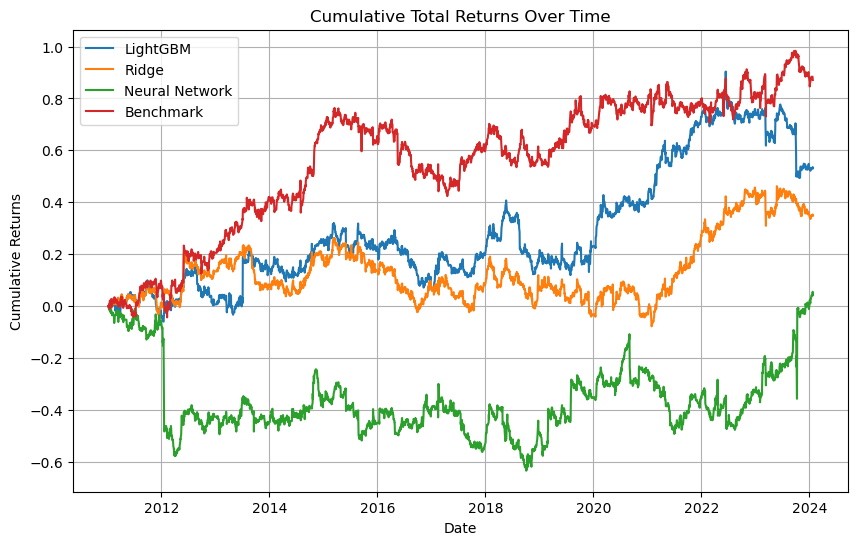

In [81]:
import matplotlib.pyplot as plt

# Sum the returns across all assets for each day to get the daily total returns for each model
lgb_total_returns = lgb_returns.sum(axis=1)
ridge_total_returns = ridge_returns.sum(axis=1)
NN_total_returns = NN_returns.sum(axis=1)
benchmark_total_returns = benchmark_returns.sum(axis=1)

lgb_cumulative_total_returns = lgb_total_returns.cumsum()
ridge_cumulative_total_returns = ridge_total_returns.cumsum()
NN_cumulative_total_returns = NN_total_returns.cumsum()
benchmark_cumulative_total_returns = benchmark_total_returns.cumsum()

# Plot the cumulative total returns for each model
plt.figure(figsize=(10, 6))
plt.plot(lgb_cumulative_total_returns, label='LightGBM')
plt.plot(ridge_cumulative_total_returns, label='Ridge')
plt.plot(NN_cumulative_total_returns, label='Neural Network')
plt.plot(benchmark_cumulative_total_returns, label='Benchmark')
plt.title('Cumulative Total Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()



In [84]:
%reload_ext autoreload
%autoreload 2
ridge_metrics = financial_metrics(ridge_total_returns, ridge_weights)
lgb_metrics = financial_metrics(lgb_total_returns, lgb_weights)
NN_metrics = financial_metrics(NN_total_returns,NN_weights )
benchmark_metrics = financial_metrics(benchmark_total_returns, benchmark_weights)
metrics = {
    "Ridge": ridge_metrics,
    "LightGBM": lgb_metrics,
    "Neural Network": NN_metrics,
    "Benchmark": benchmark_metrics
}

metrics_df = pd.DataFrame(metrics).T  


In [85]:
metrics_df

,Average Yearly Return,Average Yearly Standard Deviation,Yearly Sharpe Ratio,Max Drawdown,Yearly Volatility,Calmar Ratio,Skewness,Kurtosis,Yearly Trades,Yearly Turnover,Yearly Transaction Costs
Ridge,0.026170,0.136560,0.191634,-0.287758,0.136560,0.090943,-0.214612,8.864916,2174.142857,349.488059,0.034949
LightGBM,0.039886,0.148181,0.269168,-0.336139,0.148181,0.118658,0.125773,26.368114,1971.785714,405.365334,0.040537
Neural Network,0.003179,0.192174,0.016543,-0.466840,0.192174,0.006810,0.582385,59.944193,2092.785714,609.337112,0.060934
Benchmark,0.065418,0.159902,0.409111,-0.286982,0.159902,0.227950,-0.672436,12.296411,676.285714,143.349277,0.014335


In [86]:
ridge_turnover = ridge_weights.diff().abs().sum(axis=1)
lgb_turnover = lgb_weights.diff().abs().sum(axis=1)
NN_turnover = NN_weights.diff().abs().sum(axis=1)
bench_turnover = benchmark_weights.diff().abs().sum(axis=1)


ridge_trans_cost = ridge_turnover * 0.01 *0.01
lgb_trans_cost = lgb_turnover * 0.01 * 0.01
NN_trans_cost = NN_turnover * 0.01 * 0.01
bench_trans_cost = bench_turnover * 0.01 * 0.01

ridge_adjusted_returns = ridge_total_returns - ridge_trans_cost
lgb_adjusted_returns = lgb_total_returns - lgb_trans_cost
NN_adjusted_returns = NN_total_returns - lgb_trans_cost
bench_adjusted_returns = benchmark_total_returns - bench_trans_cost

ridge_cumulative_total_returns_post_cost = ridge_adjusted_returns.cumsum()
lgb_cumulative_total_returns_post_cost = lgb_adjusted_returns.cumsum()
NN_cumulative_total_returns_post_cost = NN_adjusted_returns.cumsum()
bench_cumulative_total_returns_post_cost = bench_adjusted_returns.cumsum()



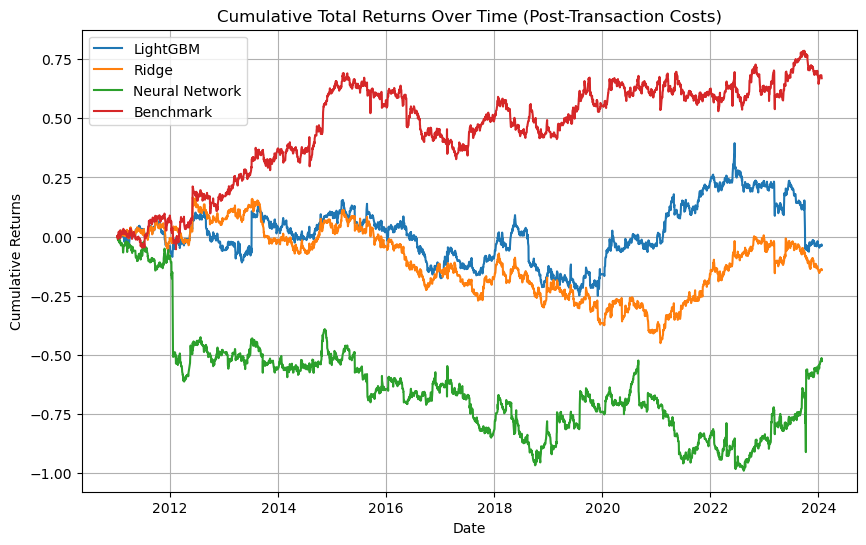

In [87]:



# Plot the cumulative total returns for each model
plt.figure(figsize=(10, 6))
plt.plot(lgb_cumulative_total_returns_post_cost, label='LightGBM')
plt.plot(ridge_cumulative_total_returns_post_cost, label='Ridge')
plt.plot(NN_cumulative_total_returns_post_cost, label='Neural Network')
plt.plot(bench_cumulative_total_returns_post_cost, label='Benchmark')
plt.title('Cumulative Total Returns Over Time (Post-Transaction Costs)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

